# Smooth arclength interpolation

## The problem

Say we have an ordered set of points $u_1, \ldots, u_n \in \mathbb{R}^N$ and we want to make a lightweight $C^1$ smooth interpolation by arc-length $\tilde{\gamma}: [0,T] \rightarrow \mathbb{R}^N$ through these points. The first part is easy, just pick your favorite established interpolation method that achieves $C^1$ smoothness. The arc-length part however turns out to be quite [nasty](https://ijpam.eu/contents/2006-31-3/10/10.pdf). Here I propose a method that is quite general (the linked article only considers curves in $\mathbb{R}^2$), and cheap to compute. 

## The 2-dimensional case

2 is the smallest number of dimensions in which the posed problem is non-trivial. Say we use an established (non arc-length) interpolation method for our set of points to obtain the $C^1$ curve

$$
    \gamma : [0, T] \rightarrow \mathbb{R}^2
$$

for which 

$$
    \gamma(t_i) = u_i \quad i = 1, \ldots, n,
$$

given a suitable set of 'time' values 

$$
    0 = t_1 < t_2 < \ldots < t_n = T,
$$

for instance

$$
    t_i = \sum_{k=1}^{i-1} \|u_{k+1} - u_k\|_2.
$$

We now want to approximate $\gamma$ piecewise with sections that are trivially parameterizable by arc-length, namely line segments and circle segments. To do this, we fix some $m \in \mathbb{N}$ and define a refined set of time points $\left(\tilde{t}_j\right)_{j=1}^{m(n-1) + 1}$ given by

$$
    \tilde{t}_{m(k-1) + l} = t_k + \frac{l}{m + 1}(t_{k+1} - t_k), \quad k = 1 \ldots n-1, \; l = 1, \ldots m.
$$

In these refined time points we evaluate $\gamma$ and its normalized derivative:

$$
    \tilde{u}_j = \gamma\left(\tilde{t}_j\right), \; \tilde{d}_j = \frac{\dot{\gamma}\left(\tilde{t}_j\right)}{\|\dot{\gamma}\left(\tilde{t}_j\right)\|_2}, \qquad j = 1, \ldots, m(n-1) + 1.
$$

As a first step to create the interpolation by arc length $\tilde{\gamma}$, we make a piecewise linear curve which is tangent to $\gamma$ in $\tilde{u}_j$ for each line segment, where we denote the intersection of consecutive tangent lines by $\tilde{u}_{j, \text{int}}$:

$$
    \begin{align*}
    \tilde{u}_{j, \text{int}} &=& \tilde{u}_j + \frac{\langle\tilde{u}_{j+1}-\tilde{u}_j, \tilde{d}_j\rangle - \langle\tilde{d}_j, \tilde{d}_{j+1}\rangle \langle\tilde{u}_{j+1}-\tilde{u}_j, \tilde{d}_{j+1}\rangle}{1 - \langle\tilde{d}_j, \tilde{d}_{j+1}\rangle^2}\tilde{d}_j \\
    &=& \tilde{u}_{j+1} + \frac{\langle\tilde{d}_j, \tilde{d}_{j+1}\rangle\langle\tilde{u}_{j+1}-\tilde{u}_j, \tilde{d}_j\rangle - \langle\tilde{u}_{j+1}-\tilde{u}_j, \tilde{d}_{j+1}\rangle}{1 - \langle\tilde{d}_j, \tilde{d}_{j+1}\rangle^2}\tilde{d}_{j+1}.
    \end{align*}
$$

As expected this doesn't work for $\langle\tilde{d}_j, \tilde{d}_{j+1}\rangle^2 = 1$, which means that the consecutive tangent lines are parallel. In fact, in the above equation we want the coefficient of $\tilde{d}_j$ to be positive and the coefficient of $\tilde{d}_{j+1}$ to be negative, to ensure that $\tilde{u}_{j, \text{int}}$ lies properly in between $\tilde{u}_j$ and $\tilde{u}_{j+1}$.

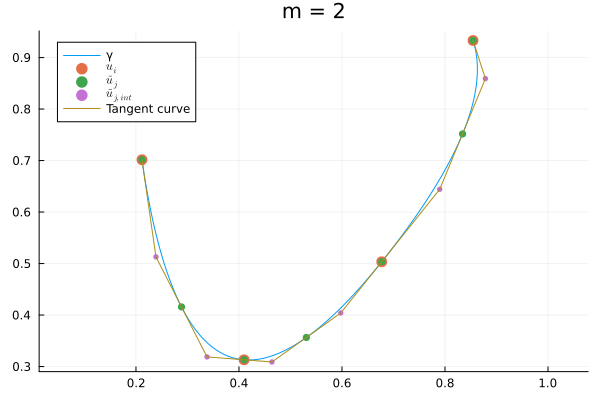

In [17]:
using DataInterpolations
using Plots
using Random
using LinearAlgebra

Random.seed!(4)

n = 4
m = 2
u = [rand(2) for _ in 1:n]
t = cumsum(norm.(diff(u)))
pushfirst!(t, 0)

γ = QuadraticSpline(u, t)

t_eval = range(first(t), last(t), length = 250)
u_eval = hcat(γ.(t_eval)...)

t_tilde = zeros(m * (n - 1) + 1)

for k in 1:(n-1)
    t_tilde[m * (k - 1) + 1 : m * k] = range(t[k], t[k+1], length = m + 1)[1:(end - 1)]
end

t_tilde[end] = t[end]
u_tilde = hcat(γ.(t_tilde)...)

d_tilde = DataInterpolations.derivative.(Ref(γ), t_tilde)
normalize!.(d_tilde)
d_tilde = hcat(d_tilde...)

n_intervals = length(t_tilde) - 1
intersection_points = zeros(2, n_intervals)

u_tilde_j_int_1 = zeros(2)
u_tilde_j_int_2 = zeros(2)

for j in 1:n_intervals
    d_tilde_j = view(d_tilde, :, j)
    d_tilde_j_plus_1 = view(d_tilde, :, j + 1)
    d_inner = dot(d_tilde_j, d_tilde_j_plus_1)
    u_tilde_j = view(u_tilde, :, j)
    u_tilde_j_plus_1 = view(u_tilde, :, j + 1)
    Δu = u_tilde_j_plus_1 - u_tilde_j

    coef_1 = (dot(Δu, d_tilde_j) - d_inner * dot(Δu, d_tilde_j_plus_1))/(1 - d_inner^2)
    coef_2 = (d_inner * dot(Δu, d_tilde_j) - dot(Δu, d_tilde_j_plus_1))/(1 - d_inner^2)

    @. u_tilde_j_int_1 = u_tilde_j + coef_1 * d_tilde_j
    @. u_tilde_j_int_2 = u_tilde_j_plus_1 + coef_2 * d_tilde_j_plus_1
    @assert u_tilde_j_int_1 ≈ u_tilde_j_int_2

    intersection_points[:, j] .= u_tilde_j_int_1
end

function plot_tangent_curve()
    p = plot(; aspect_ratio = :equal, legend = :topleft, title = "m = $m")
  
    # Plot curve γ
    plot!(u_eval[1,:], u_eval[2,:]; label = raw"\gamma")

    # Plot original points
    u_ = hcat(u...)
    scatter!(u_[1,:], u_[2,:], label = raw"$u_i$"; markersize = 6, markerstrokewidth = 0)

    # Plot refined evaluation points
    scatter!(u_tilde[1,:], u_tilde[2,:]; label = raw"$\tilde{u}_j$", markerstrokewidth = 0)

    # Plot tangent curve
    scatter!(intersection_points[1, :], intersection_points[2, :]; 
    markerstrokewidth = 0, markersize = 3, label = raw"$\tilde{u}_{j, int}$")
    plot!([u_tilde[1, 1], intersection_points[1, :]..., u_tilde[1, end]], 
          [u_tilde[2, 1], intersection_points[2, :]..., u_tilde[2, end]]; 
          label = "Tangent curve")
    # xlims!(0,1)
    # ylims!(0,1)
    p
end

plot_tangent_curve()

As a last step to obtain our curve by arc length $\tilde{\gamma}$ we want to get rid of the kinks in the tangent curve. We do this by replacing sections of the tangent curve by circle arcs. For each $\tilde{u}_{j, \text{int}}$ we compute the shortest distance to the neighboring evaluation points on $\gamma$:

$$
    \delta_j = \min\left\{
        \|\tilde{u}_j - \tilde{u}_{j, \text{int}}\|_2, 
        \|\tilde{u}_{j + 1} - \tilde{u}_{j, \text{int}}\|_2
    \right\}.
$$

From this we compute 2 points that are on the tangent curve and equidistant from $\tilde{u}_{j  + \frac{1}{2}}$:

$$
    \tilde{u}_{j, \text{start}} = \tilde{u}_{j, \text{int}} - \delta_j \tilde{d}_j, 
$$

$$
    \tilde{u}_{j, \text{end}} = \tilde{u}_{j, \text{int}} + \delta_j \tilde{d}_{j+1}.
$$

Note that by this definition

$$
    \tilde{u}_{j, \text{start}} = \tilde{u}_j \quad \vee \quad \tilde{u}_{j, \text{end}} = \tilde{u}_{j  + 1}.
$$

Now we can define a circle arc from $\tilde{u}_{j, \text{start}}$ to $\tilde{u}_{j, \text{end}}$ given the center

$$
    c_j = \tilde{u}_{j, \text{int}} + \delta_j\frac{\tilde{d}_{j+1} - \tilde{d}_j}{1 - \langle\tilde{d}_j,\tilde{d}_{j+1}\rangle}
$$

and radius

$$
    R_j = \delta_j\sqrt{\frac{1 + \langle\tilde{d}_j,\tilde{d}_{j+1}\rangle}{1 - \langle\tilde{d}_j,\tilde{d}_{j+1}\rangle}}.
$$

We obtain the circle arc

$$
    c_j + \cos\left(\frac{t}{R_j}\right)v_{j, 1} + \sin\left(\frac{t}{R_j}\right)v_{j, 2}, \quad t \in [0, \Delta t_{j, \text{arc}}],
$$

where

$$
    v_{j, 1} = -\delta_j \frac{\tilde{d}_{j+1} - \langle\tilde{d}_j,\tilde{d}_{j+1}\rangle\tilde{d}_j}{1 - \langle\tilde{d}_j,\tilde{d}_{j+1}\rangle},
    \quad
    v_{j, 2} = R_j \tilde{d}_j.
$$

By this definition $\|v_{j, 1}\|_2 = \|v_{j, 2}\|_2 = R_j$ and $\langle v_{j, 1}, v_{j, 2}\rangle = 0$. Furthermore:

$$
    \Delta t_{j, \text{arc}} = R_j\theta_{j, \;\max}= 2R_j \arctan\left(\frac{\delta_j}{R_j}\right).
$$

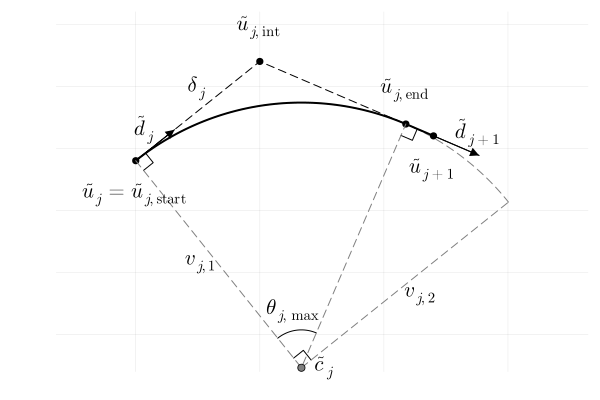

In [18]:
function mark_right_angle!(corner, dir1, dir2; l = 0.05)
    points = zeros(3, 2)
    points[1, :] = corner + l * dir1
    points[2, :] = points[1, :] + l * dir2
    points[3, :] = points[2, :] - l * dir1
    
    plot!(points[:, 1], points[:, 2]; color = :black, label = "")
end

function plot_arc_construction(; indicate_delta = true)
    p = plot(; aspect_ratio = :equal, axis = false)

    tu_j = [0.0, 0.2]
    tu_j_int = [0.5, 0.6]
    tu_j_plus_1 = [1.2, 0.3]
    δⱼ = norm(tu_j_int - tu_j)
    tu_j_start = tu_j
    tu_j_end = tu_j_int + δⱼ * (tu_j_plus_1 - tu_j_int) / norm(tu_j_plus_1 - tu_j_int)

    td_j = tu_j_int - tu_j
    normalize!(td_j)
    td_j_plus_1 = tu_j_plus_1 - tu_j_int
    normalize!(td_j_plus_1)
    inner = dot(td_j, td_j_plus_1)
    Δtd_j = td_j_plus_1 - td_j

    tc_j = tu_j_int + δⱼ / (1 - inner) * Δtd_j

    Rⱼ = δⱼ * sqrt((1 + inner)/(1 - inner))
    vⱼ₁ = -δⱼ * (td_j_plus_1 - inner * td_j)/(1 - inner)
    vⱼ₂ = Rⱼ * td_j
    Δt_j_arc = 2 * Rⱼ * atan(δⱼ, Rⱼ)

    T_ = range(0, π/2; length = 100)
    x_arc = @. tc_j[1] + cos(T_) * vⱼ₁[1] + sin(T_) * vⱼ₂[1]
    y_arc = @. tc_j[2] + cos(T_) * vⱼ₁[2] + sin(T_) * vⱼ₂[2]
    plot!(x_arc, y_arc;  label = "", color = :gray, ls = :dash)
    
    T = range(0, Δt_j_arc, length = 100)
    X_arc = @. tc_j[1] + cos(T/Rⱼ) * vⱼ₁[1] + sin(T/Rⱼ) * vⱼ₂[1]
    Y_arc = @. tc_j[2] + cos(T/Rⱼ) * vⱼ₁[2] + sin(T/Rⱼ) * vⱼ₂[2]
    plot!(X_arc, Y_arc;  label = "", color = :black, linewidth = 2)

    x_arc = @. tc_j[1] + cos(T/Rⱼ) * vⱼ₁[1] / 7 + sin(T/Rⱼ) * vⱼ₂[1] / 7
    y_arc = @. tc_j[2] + cos(T/Rⱼ) * vⱼ₁[2] / 7 + sin(T/Rⱼ) * vⱼ₂[2] / 7
    plot!(x_arc, y_arc;  label = "", color = :black)

    z = tc_j + vⱼ₂

    annotate!(tu_j...,  "\n\n\n" * raw"$\tilde{u}_j = \tilde{u}_{j, \mathrm{start}}$")
    annotate!(tu_j_int..., raw"$\tilde{u}_{j, \mathrm{int}}$" * "\n\n\n")
    annotate!(tu_j_end...,  raw"$\tilde{u}_{j, \mathrm{end}}$" * "\n\n\n")
    annotate!(tu_j_plus_1..., "\n\n\n" * raw"$\tilde{u}_{j + 1}$")
    annotate!((tu_j + td_j/5)..., raw"$\tilde{d}_j$" * "         ")
    annotate!((tu_j_plus_1 + td_j_plus_1/5)..., raw"$\tilde{d}_{j+1}$" * "\n\n")
    annotate!(tc_j..., "       " * raw"$\tilde{c}_j$")
    annotate!(tc_j + vⱼ₁/2..., raw"$v_{j,1}$" * "     ")
    annotate!(tc_j + vⱼ₂/2..., "\n     " * raw"$v_{j,2}$")
    annotate!(tc_j..., raw"$\theta_{j, \max}$" * "  \n\n\n\n\n")
    indicate_delta && annotate!((tu_j + tu_j_int)/2..., raw"$\delta_j$" * "\n\n")

    mark_right_angle!(tu_j_start, td_j, normalize(tc_j - tu_j_start))
    mark_right_angle!(tu_j_end, td_j_plus_1, normalize(tc_j - tu_j_end))
    mark_right_angle!(tc_j, normalize(vⱼ₁), normalize(vⱼ₂))

    # u connections
    points = hcat(tu_j, tu_j_int, tu_j_end, tu_j_plus_1)
    plot!(points[1, :], points[2, :]; marker = :circle, c = :black, ls = :dash, label = "")

    # line segment
    plot!([tu_j_plus_1[1], tu_j_end[1]], [tu_j_plus_1[2], tu_j_end[2]], c = :black, label = "", linewidth = 2)

    # td_j and td_j_plus_1
    plot!([tu_j[1], tu_j[1] + td_j[1]/5], [tu_j[2], tu_j[2] + td_j[2]/5]; arrow=(:closed, 2.0), color = :black, label = "")
    plot!([tu_j_plus_1[1], tu_j_plus_1[1] + td_j_plus_1[1]/5], [tu_j_plus_1[2], tu_j_plus_1[2] + td_j_plus_1[2]/5]; arrow=(:closed, 2.0), color = :black, label = "")

    # Circle segment radii
    points = hcat(tu_j_start, tc_j, tu_j_end)
    plot!(points[1, :], points[2, :]; color = :gray, label = "", ls = :dash)

    # v₂ⱼ
    points = hcat(tc_j, tc_j + vⱼ₂)
    plot!(points[1, :], points[2, :]; color = :gray, label = "", ls = :dash)

    # tc_j
    scatter!([tc_j[1]], [tc_j[2]]; color = :gray, label = "")
    ylims!(-0.65, 0.8)
    return p, (; tu_j, tu_j_plus_1, tu_j_int, tu_j_start, tu_j_end, td_j, td_j_plus_1, inner, tc_j, δⱼ, Rⱼ)
end

plot_arc_construction()[1]

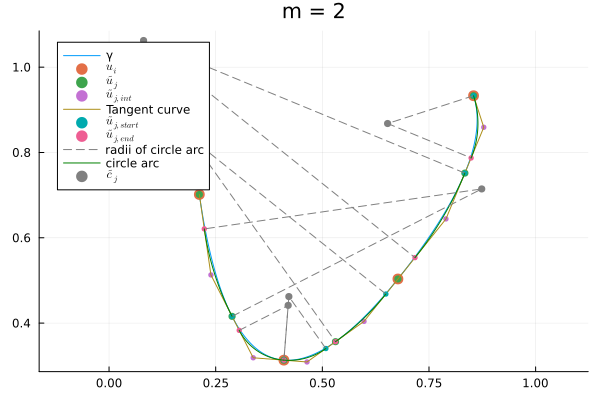

In [19]:
p = plot_tangent_curve()

δ = [min(
    norm(intersection_points[:, j] - u_tilde[:, j]), 
    norm(intersection_points[:, j] - u_tilde[:, j+1])
    ) 
    for j in 1:n_intervals
]

u_tilde_start = zeros(2, n_intervals)
u_tilde_end = zeros(2, n_intervals)

for j in 1:n_intervals
    u_tilde_intⱼ = intersection_points[:, j]
    u_tildeⱼ = u_tilde[:, j]
    u_tildeⱼ₊₁ = u_tilde[:, j + 1]
    d_tildeⱼ = d_tilde[:, j]
    d_tildeⱼ₊₁ = d_tilde[:, j + 1]

    u_tilde_start[:, j] = u_tilde_intⱼ - δ[j] * d_tildeⱼ
    u_tilde_end[:, j]   = u_tilde_intⱼ + δ[j] * d_tildeⱼ₊₁
end

scatter!(u_tilde_start[1, :], u_tilde_start[2, :]; markersize = 3, markerstrokewidth = 0, 
    label = raw"$\tilde{u}_{j, start}$")
scatter!(u_tilde_end[1, :], u_tilde_end[2, :]; markersize = 3, markerstrokewidth = 0,
    label = raw"$\tilde{u}_{j, end}$")

origins = zeros(2, n_intervals)

for j in 1:n_intervals
    u_tilde_intⱼ = intersection_points[:, j]
    d_tildeⱼ = d_tilde[:, j]
    d_tildeⱼ₊₁ = d_tilde[:, j + 1]
    inner = dot(d_tildeⱼ, d_tildeⱼ₊₁)

    origins[:, j] = u_tilde_intⱼ + δ[j] / (1 - inner) * (d_tildeⱼ₊₁ - d_tildeⱼ)

    plot!([u_tilde_start[1, j], origins[1, j], u_tilde_end[1, j]], 
          [u_tilde_start[2, j], origins[2, j], u_tilde_end[2, j]]; 
          label = (j ==1) ? "radii of circle arc" : "", ls = :dash, c = :gray)

    Rⱼ = δ[j] * sqrt((1 + inner)/(1 - inner))
    v₁ = -δ[j] * (d_tildeⱼ₊₁ - inner * d_tildeⱼ) / (1 - inner)
    v₂ = Rⱼ * d_tildeⱼ
    Δt = 2 * Rⱼ * atan(δ[j], Rⱼ)
    T = range(0, Δt, length = 25)
    x = @. origins[1, j] + cos(T/Rⱼ) * v₁[1] + sin(T/Rⱼ) * v₂[1]
    y = @. origins[2, j] + cos(T/Rⱼ) * v₁[2] + sin(T/Rⱼ) * v₂[2]
    plot!(x,y; c = :green, label = (j == 1) ? "circle arc" : "")
end

scatter!(origins[1, :], origins[2, :]; label = raw"$\tilde{c}_j$", c= :gray, markerstrokewidth = 0)

p

That's pretty neat, but this method does not directly generalize to higher dimensional spaces. That is because in general the intersection points $\tilde{u}_{j, \text{int}}$ of the tangent lines do not exist.

## The higher dimensional case

Let's try to generalize the method above. The goal is to find a point $\tilde{u}_{j + \frac{1}{2}}$ and unit direction $\tilde{d}_{j + \frac{1}{2}}$ to add to the tangent curve between $\tilde{u}_j$ and $\tilde{u}_{j+1}$ such that:

- the tangent line intersections $\tilde{u}_{j, \text{int left}}, \tilde{u}_{j, \text{int right}}$ exist. This means that the new line is fixed by these 2 points; 
- constructing $\tilde{\gamma}$ including this point gives gives an identical result to constructing $\tilde{\gamma}$ excluding this point if the tangent line intersection already existed. The latter implies that $\tilde{u}_{j + \frac{1}{2}}$ and $\tilde{d}_{j + \frac{1}{2}}$ yield a tangent line to the constructed circle arc.

Let's assume the tangent line intersection exists, and we define

$$
    \tilde{u}_{j, \text{int left}} = \tilde{u}_{j, \text{int}} - \delta_j^* \tilde{d}_{j},
$$
$$
    \tilde{u}_{j, \text{int right}} = \tilde{u}_{j, \text{int}} + \delta_j^* \tilde{d}_{j+1}.
$$

It turns out that if we then let

$$
\delta^*_j = \delta_j \frac{2 - \sqrt{2 + 2 \langle\tilde{d}_j, \tilde{d}_{j+1}\rangle}}{1 - \langle\tilde{d}_j, \tilde{d}_{j+1}\rangle},
$$

The line between $\tilde{u}_{, \text{int left}}$ and $ \tilde{u}_{, \text{int right}}$ touches the circle arc as constructed before. It follows that

$$
    \tilde{u}_{j + \frac{1}{2}} = \frac{1}{2}\left[\tilde{u}_{j, \text{int left}} + \tilde{u}_{j, \text{int right}}\right],
    \qquad
    \tilde{d}_{j + \frac{1}{2}} = \frac{\tilde{u}_{j, \text{int right}} - \tilde{u}_{j, \text{int left}}}{\|\tilde{u}_{j, \text{int right}} - \tilde{u}_{j, \text{int left}}\|_2}.
$$

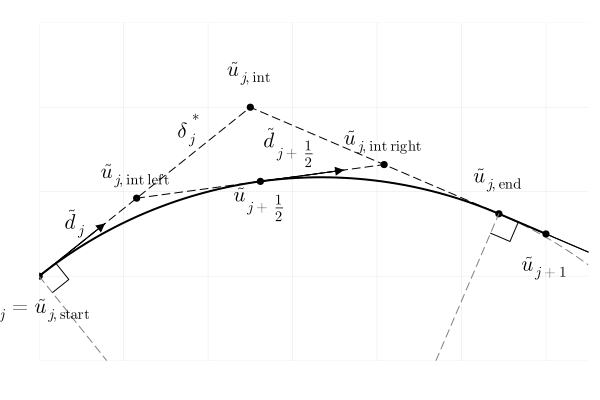

In [27]:
p, vars = plot_arc_construction(; indicate_delta = false)
xlims!(0.0, 1.3)
ylims!(0.0, 0.8)
δⱼ_star = vars.δⱼ * (2 - sqrt(2 + 2 * vars.inner)) / (1 - vars.inner)
tu_j_int_left = vars.tu_j_int - δⱼ_star * vars.td_j
tu_j_int_right = vars.tu_j_int + δⱼ_star * vars.td_j_plus_1
tu_j_plus_half = vars.tu_j_int + δⱼ_star / 2 * (vars.td_j_plus_1 - vars.td_j)
td_j_plus_half = (vars.td_j_plus_1 + vars.td_j) / sqrt(2 + 2 * vars.inner)

scatter!([tu_j_int_left[1], tu_j_plus_half[1], tu_j_int_right[1]], 
         [tu_j_int_left[2], tu_j_plus_half[2], tu_j_int_right[2]]; color = :black, label = "")
annotate!(tu_j_int_left..., raw"$\tilde{u}_{j, \mathrm{int \; left}}$" * "\n\n")
annotate!(tu_j_int_right..., raw"$\tilde{u}_{j, \mathrm{int \; right}}$" * "\n\n")
annotate!(tu_j_plus_half..., "\n\n" * raw"$\tilde{u}_{j + \frac{1}{2}}$")
annotate!(tu_j_plus_half..., "         " * raw"$\tilde{d}_{j + \frac{1}{2}}$" * "\n\n\n")
annotate!((vars.tu_j_int + δⱼ_star / 2 * normalize(vars.tu_j - vars.tu_j_int))..., raw"$\delta^*_j$" * "\n\n")
plot!(
    [vars.tu_j_int[1] - δⱼ_star * vars.td_j[1], vars.tu_j_int[1] + δⱼ_star * vars.td_j_plus_1[1]],
    [vars.tu_j_int[2] - δⱼ_star * vars.td_j[2], vars.tu_j_int[2] + δⱼ_star * vars.td_j_plus_1[2]];
    color = :black, ls = :dash, label = "")
plot!([tu_j_plus_half[1], tu_j_plus_half[1] + td_j_plus_half[1]/5], 
      [tu_j_plus_half[2], tu_j_plus_half[2] + td_j_plus_half[2]/5]; 
       arrow=(:closed, 2.0), color = :black, label = "")

p

If we generalize the definition of $\tilde{u}_{j, \text{int}}$ then we can compute  $\tilde{u}_{j + \frac{1}{2}}$ and $\tilde{d}_{j + \frac{1}{2}}$ as above. Something we can always compute are the points on the tangent lines which are closest together, given by:

$$
    \argmin_{s,\; t \;\in\; \mathbb{R}} \|\tilde{u}_{j+1} + s\tilde{d}_{j+1} - (\tilde{u}_j + t\tilde{d}_j)\|_2.
$$

This yields 

$$
    \tilde{u}_{j, \text{close left}} = \tilde{u}_j + \frac{\langle\tilde{u}_{j+1}-\tilde{u}_j, \tilde{d}_j\rangle - \langle\tilde{d}_j, \tilde{d}_{j+1}\rangle \langle\tilde{u}_{j+1}-\tilde{u}_j, \tilde{d}_{j+1}\rangle}{1 - \langle\tilde{d}_j, \tilde{d}_{j+1}\rangle^2}\tilde{d}_j,
$$
$$
    \tilde{u}_{j, \text{close right}} = \tilde{u}_{j+1} + \frac{\langle\tilde{d}_j, \tilde{d}_{j+1}\rangle\langle\tilde{u}_{j+1}-\tilde{u}_j, \tilde{d}_j\rangle - \langle\tilde{u}_{j+1}-\tilde{u}_j, \tilde{d}_{j+1}\rangle}{1 - \langle\tilde{d}_j, \tilde{d}_{j+1}\rangle^2}\tilde{d}_{j+1}.
$$

This is the same as the two expressions for $\tilde{u}_{j, \text{int}}$ from before, except now these expressions aren't necessarily equal. We define $\tilde{u}_{j, \text{int}}$ as the average of these expressions:

$$
    \tilde{u}_{j, \text{int}} = \frac{\tilde{u}_{j, \text{close left}} + \tilde{u}_{j, \text{close right}}}{2}.
$$

From this $\delta_j$ and $\delta_j^*$ follow, and 

$$
    \tilde{u}_{j, \text{int left}} = \tilde{u}_{j, \text{close left}} - \delta_j^* \tilde{d}_{j},
$$
$$
    \tilde{u}_{j, \text{int right}} = \tilde{u}_{j, \text{close right}} + \delta_j^* \tilde{d}_{j+1}.
$$

In [21]:
using DataInterpolations: SmoothArcLengthInterpolation

Random.seed!(1)

n = 4
u = rand(3, n)
A = SmoothArcLengthInterpolation(u; m = 5)

SmoothArcLengthInterpolation with 31 points
┌───────────┬─────────────┬──────────┬──────────┐
│      time │          u1 │       u2 │       u3 │
├───────────┼─────────────┼──────────┼──────────┤
│       0.0 │   0.0491718 │ 0.119079 │ 0.393271 │
│ 0.0703603 │   0.0269864 │ 0.153539 │ 0.450413 │
│  0.137097 │  0.00971137 │ 0.192336 │ 0.501846 │
│  0.203801 │ -0.00355192 │  0.23671 │ 0.549797 │
│  0.270541 │  -0.0125266 │ 0.286242 │ 0.593559 │
│  0.337314 │  -0.0172039 │  0.34013 │  0.63265 │
│  0.407777 │  -0.0175421 │ 0.400798 │ 0.668408 │
│  0.478301 │  -0.0138159 │ 0.464221 │ 0.698958 │
│     ⋮     │      ⋮      │    ⋮     │    ⋮     │
│   1.03979 │    0.204067 │ 0.911244 │ 0.824877 │
│   1.09888 │    0.257848 │ 0.887916 │ 0.826758 │
│   1.15943 │    0.307302 │ 0.853081 │ 0.826189 │
│   1.25314 │    0.372683 │ 0.786276 │ 0.821875 │
│   1.34719 │    0.432338 │ 0.713833 │ 0.815967 │
│   1.47879 │    0.507208 │ 0.606141 │ 0.805672 │
│   1.61049 │    0.577164 │ 0.495155 │ 0.794274 │
│   1.

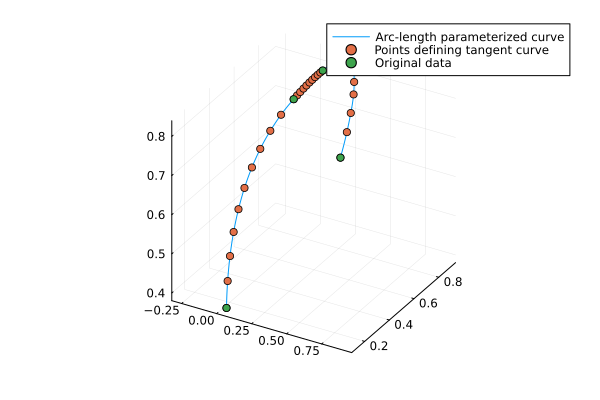

In [22]:
n_eval = 500
t_eval = range(0, last(A.t), n_eval)
u_eval = zeros(3, n_eval)

for (i, t) in enumerate(t_eval)
    u_eval[:, i] = A(t)
end

p = plot(; aspect_ratio = :equal)

plot!(u_eval[1, :], u_eval[2, :], u_eval[3, :]; label = "Arc-length parameterized curve")
scatter!(A.u[1, :], A.u[2, :], A.u[3, :]; label = "Points defining tangent curve")
scatter!(u[1, :], u[2, :], u[3, :]; label = "Original data")

p

It would be nice to have a rigorous proof of $\tilde{\gamma}$ converging to the arc-length reparametrization of $\gamma$ as $m \rightarrow \infty$ (and how fast). For now we can look at the convergence of the arc-length of $\tilde{\gamma}$ to the arc-length of $\gamma$ with $m$ for the example above: 

In [23]:
M = 5:1000
E = zeros(length(M))

(; shape_itp) = A
t_eval = range(0, last(shape_itp.t), length = 1_000_000)
u_eval = shape_itp.(t_eval)
l = sum(norm.(diff(u_eval)))


for (i, m) in enumerate(M)
    A = SmoothArcLengthInterpolation(u; m)
    E[i] = abs(l - last(A.t))
end

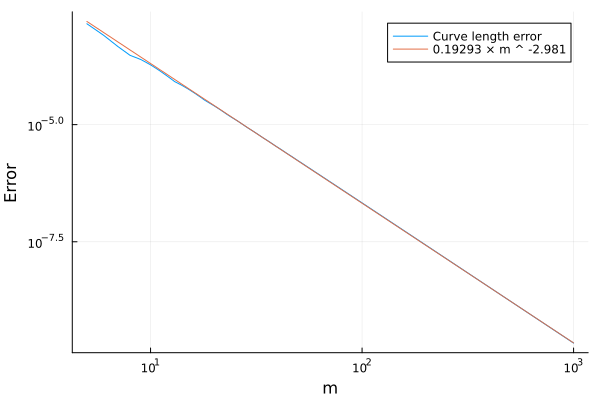

In [24]:
p = plot()
xlabel!("m")
ylabel!("Error")
plot!(M, E; xscale = :log10, yscale = :log10, label = "Curve length error")

ε = log.(E)
μ = log.(M)
k = (dot(ε, μ) - sum(ε)*sum(μ)/length(M))/(dot(μ,μ) - (sum(μ)^2)/length(M))
C = exp((sum(ε) - k*sum(μ))/length(M))


plot!(M, @. C * M^k; label = "$(round(C, digits = 5)) × m ^ $(round(k, digits = 3))")